In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
#from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn


In [204]:
def my_plot_style():
   
    params = {'legend.fontsize': 20,
             'axes.labelsize': 20,
             'axes.titlesize':20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'xtick.major.size':5,
              'xtick.minor.size':2.5,
             'ytick.major.size':5,
              'ytick.minor.size':2.5,
             'figure.facecolor':'w',
             #'lines.linewidth' : 1.5,
              'xtick.major.width':1.5,
              'ytick.major.width':1.5,
              'xtick.minor.width':1.5,
              'ytick.minor.width':1.5,
              'axes.linewidth':1.5,
              'xtick.direction':'in',
              'ytick.direction':'in',
             'ytick.labelleft':True,
              'text.usetex' : False,
             'font.family': 'sans-serif'}
  
    plt.rcParams.update(params)

In [205]:
directory_everest = '/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/'
everest_all = Table.read(directory_everest+'ztile-sv1-dark-cumulative.fits')
everest_bright = Table.read(directory_everest+'ztile-sv1-bright-cumulative.fits')


new_catalog_everest = everest_all['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                              ,'FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','PHOTSYS'].to_pandas()
new_catalog_everest_bright = everest_bright['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                              ,'FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','PHOTSYS'].to_pandas()

new_catalog_everest=new_catalog_everest.append(new_catalog_everest_bright)


In [206]:
fuji_all = pd.read_csv('Fuji_f1_test.csv')
# Compiled from /global/cfs/cdirs/desi/spectro/redux/f1

In [207]:
def give_me_combine_catalog(target_name,everest_data,denali_data):
    if target_name=='BGS':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
        dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
    
    elif target_name=='LRG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
        dataname = 'allVItiles_LRGzinfo_wVI.fits'
    
    elif target_name=='ELG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/ELG/'
        dataname = 'allVItiles_ELGzinfo_wVI.fits'

    elif target_name=='QSO':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/QSO/'
        dataname = 'allVItiles_QSOzinfo_wVI.fits'
            
    VI_data = Table.read(diretory+dataname)
    VI_data = VI_data[(VI_data['subset']=='deep') & (VI_data['subset']!='All') & ((VI_data['N_VI']>0))]
    VI_data = VI_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                        ,'FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','best_z','best_quality','N_VI','all_VI_comments','merger_comment'].to_pandas()

        
    catalog_match = everest_data.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    final_match_catalog = catalog_match[catalog_match['TILEID']==catalog_match['TILEID_VI']]

    final_match_catalog = final_match_catalog.merge(denali_data,on='TARGETID',how='left',suffixes=("","_denali"))
    final_match_catalog = final_match_catalog[final_match_catalog['TILEID']==final_match_catalog['TILEID_denali']]
    final_match_catalog['dz_fuji']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_everest']=abs(final_match_catalog['Z_denali']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_cascades']=abs(final_match_catalog['Z_VI']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

    return final_match_catalog

In [208]:
def give_me_dz_inconsistent_statistics(data):
    good_data = data.loc[(data['best_quality']>=2.5) & (data['ZWARN']<=4)]
    all_n = len(data['best_quality'])
    total_good_n = len(good_data)
    total_dz_inconsistent_everest = len(good_data.loc[good_data['dz_fuji']>=0.0033])
    total_dz_inconsistent_denali = len(good_data.loc[good_data['dz_everest']>=0.0033])
    total_dz_inconsistent_cascades = len(good_data.loc[good_data['dz_cascades']>=0.0033])
    print('Number of best quality>=2.5 & zwarn<=4 spectra:%0.0f (out of %0.0f VI spectra)' % (total_good_n,all_n))
    print('Number of spectra with inconsistent redshifts vs VI best z')
    print('Fuji: %0.0f (%0.1f%%)' % (total_dz_inconsistent_everest,total_dz_inconsistent_everest*1.0/total_good_n*100.))
    print('Everest: %0.0f (%0.1f%%)' % (total_dz_inconsistent_denali,total_dz_inconsistent_denali*1.0/total_good_n*100.))
    print('Cascades: %0.0f (%0.1f%%)' % (total_dz_inconsistent_cascades,total_dz_inconsistent_cascades*1.0/total_good_n*100.))
    return {'dz_fuji':good_data.loc[good_data['dz_fuji']>=0.0033],'dz_everest':good_data.loc[good_data['dz_everest']>=0.0033]}

In [209]:
def main_survey_selection(data,target_type):
    new_catalog = data.copy()
    new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
    new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['GTOT']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['GFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['RFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['ZFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']

    new_catalog['W1']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
    
    new_catalog['RZ']=new_catalog['rmag']-new_catalog['zmag']
    new_catalog['GR']=new_catalog['gmag']-new_catalog['rmag']
    new_catalog['color']=(new_catalog['zmag']-new_catalog['W1'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
    new_catalog['ZW1']=new_catalog['zmag']-new_catalog['W1']
    new_catalog['RW1']=new_catalog['rmag']-new_catalog['W1']

    if target_type=='ELG_main':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))
    
    elif target_type=='ELG_top':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.3))
    
    elif target_type=='ELG_low':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']>-1.2*new_catalog['RZ']+1.3) & (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))

        
    elif target_type=='BGS_main':
        #SV3_selection = (
        #    ((new_catalog['PHOTSYS']==b'S') & ((new_catalog['RFIB']<20.75) | ((new_catalog['RFIB']<21.5) & (new_catalog['color']>0)))) |            
        #    ((new_catalog['PHOTSYS']==b'N') & ((new_catalog['RFIB']<20.75+0.04) | ((new_catalog['RFIB']<21.5+0.04) & (new_catalog['color']>0)))))   
        SV3_selection = (
            ((new_catalog['RFIB']<20.75+0.04) | ((new_catalog['RFIB']<21.5+0.04) & (new_catalog['color']>0))))
        #deltachi2_selection = new_catalog['DELTACHI2']>40
        #SV3_selection = SV3_selection & deltachi2_selection
    
    elif target_type=='LRG_main':
        
        SV3_selection = (
            ((new_catalog['ZFIB']<21.7) &
            (new_catalog['ZW1']>0.8*new_catalog['RZ']-0.6) & 
            (((new_catalog['GR']>1.3) & (new_catalog['GR']>-1.55*(new_catalog['RW1']+3.13))) |  (new_catalog['RW1']>1.8)) &
            (((new_catalog['RW1']>(new_catalog['W1']-17.07)*1.8) & (new_catalog['RW1']>(new_catalog['W1']-16.17)*1))  | (new_catalog['RW1']>3.29)))
            
           
        )
       # deltachi2_selection = (new_catalog['Z']>0.4) & (new_catalog['Z']<1.4) & (new_catalog['DELTACHI2']>15)
       # SV3_selection = SV3_selection & deltachi2_selection    
    return new_catalog[SV3_selection]

In [210]:
BGS_data = give_me_combine_catalog('BGS',fuji_all,new_catalog_everest)
LRG_data = give_me_combine_catalog('LRG',fuji_all,new_catalog_everest)
ELG_data = give_me_combine_catalog('ELG',fuji_all,new_catalog_everest)
QSO_data = give_me_combine_catalog('QSO',fuji_all,new_catalog_everest)

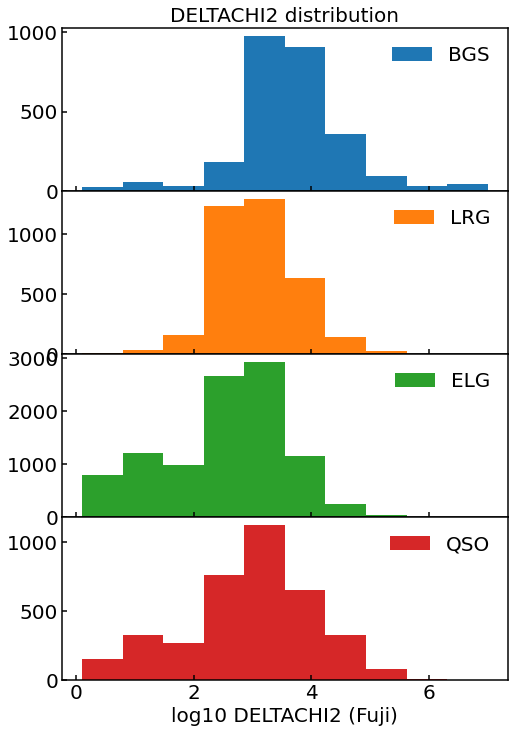

In [211]:
my_plot_style()
plt.figure(figsize=(8,12))
plt.subplots_adjust(hspace=0.0)
plt.subplot(4,1,1)
plt.hist(np.log10(BGS_data['DELTACHI2']),range=(0.1,7),label='BGS')
plt.title('DELTACHI2 distribution')
plt.legend(frameon=False)
plt.subplot(4,1,2)
plt.hist(np.log10(LRG_data['DELTACHI2']),range=(0.1,7),label='LRG',color='C1')
plt.legend(frameon=False)
plt.subplot(4,1,3)
plt.hist(np.log10(ELG_data['DELTACHI2']),range=(0.1,7),label='ELG',color='C2')
plt.legend(frameon=False)
plt.subplot(4,1,4)
plt.hist(np.log10(QSO_data['DELTACHI2']),range=(0.1,7),label='QSO',color='C3')
plt.xlabel('log10 DELTACHI2 (Fuji)',fontsize=20)
plt.legend(frameon=False)

In [220]:
print('SV1 selection')
print('---------------------------------------')
print('')
print('BGS')
BGS_dz = give_me_dz_inconsistent_statistics(BGS_data)
print('')
print('LRG ')
LRG_dz = give_me_dz_inconsistent_statistics(LRG_data)
print('')
print('ELG')
ELG_dz = give_me_dz_inconsistent_statistics(ELG_data)
print('')
print('QSO')
QSO_dz = give_me_dz_inconsistent_statistics(QSO_data)

SV1 selection
---------------------------------------

BGS
Number of best quality>=2.5 & zwarn<=4 spectra:2587 (out of 2718 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 19 (0.7%)
Everest: 24 (0.9%)
Cascades: 56 (2.2%)

LRG 
Number of best quality>=2.5 & zwarn<=4 spectra:3452 (out of 3561 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 50 (1.4%)
Everest: 65 (1.9%)
Cascades: 77 (2.2%)

ELG
Number of best quality>=2.5 & zwarn<=4 spectra:7751 (out of 10315 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 170 (2.2%)
Everest: 184 (2.4%)
Cascades: 186 (2.4%)

QSO
Number of best quality>=2.5 & zwarn<=4 spectra:3196 (out of 3761 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 209 (6.5%)
Everest: 226 (7.1%)
Cascades: 219 (6.9%)


In [213]:
BGS_dz['dz_fuji'].to_csv('Fuji_vs_VI_SV1_inconsistent_z_BGS.csv')
LRG_dz['dz_fuji'].to_csv('Fuji_vs_VI_SV1_inconsistent_z_LRG.csv')
ELG_dz['dz_fuji'].to_csv('Fuji_vs_VI_SV1_inconsistent_z_ELG.csv')
QSO_dz['dz_fuji'].to_csv('Fuji_vs_VI_SV1_inconsistent_z_QSO.csv')

Deltachi2 and Everest Redrock distribution for objects with inconsistent redshifts


(-0.1, 3.8)

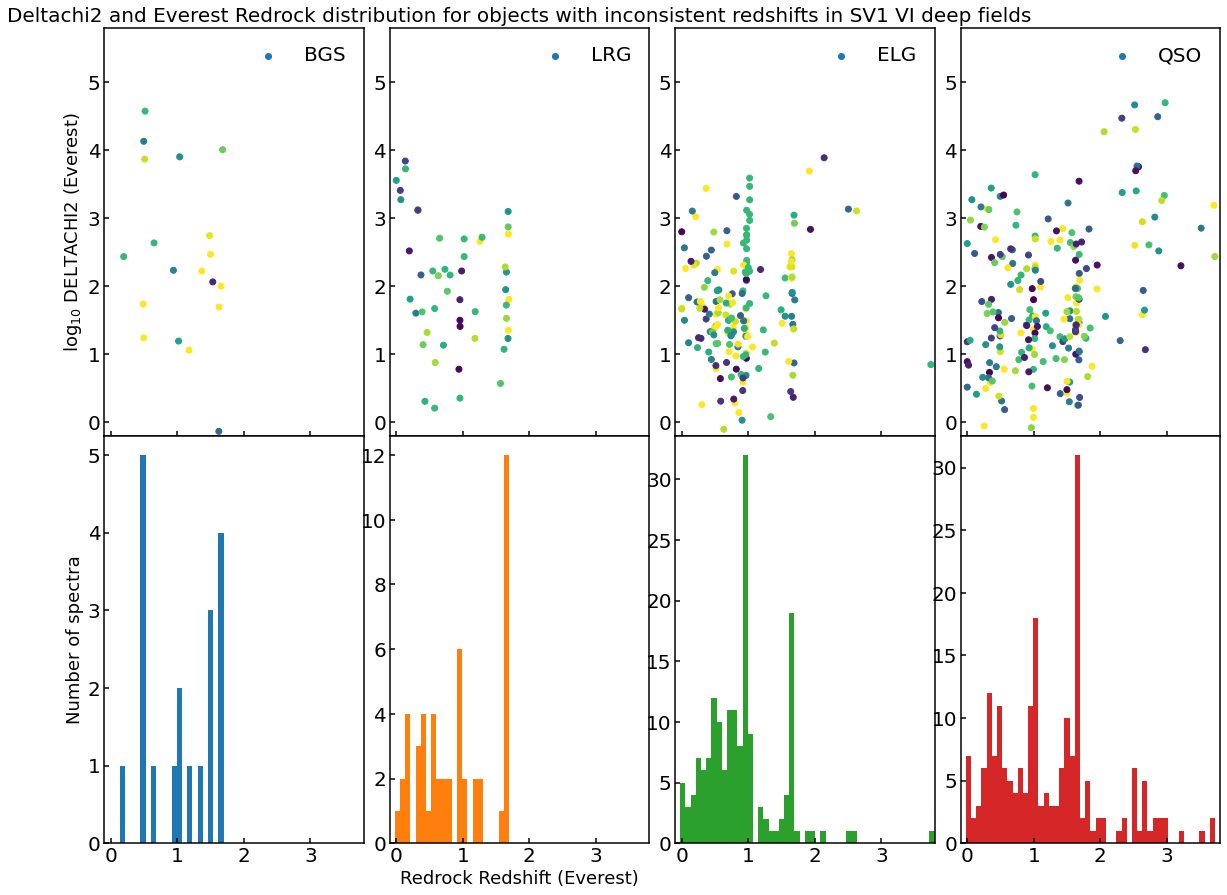

In [214]:
print('Deltachi2 and Everest Redrock distribution for objects with inconsistent redshifts')

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.,wspace=0.1)
my_plot_style()
plt.subplot(2,4,1)
plt.ylabel('$\\rm log_{10}$ DELTACHI2 (Everest)',fontsize=18)
plt.scatter(BGS_dz['dz_fuji']['Z'],np.log10(BGS_dz['dz_fuji']['DELTACHI2']),label='BGS',c=BGS_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.legend(frameon=False)
plt.subplot(2,4,2)
plt.title('Deltachi2 and Everest Redrock distribution for objects with inconsistent redshifts in SV1 VI deep fields')
plt.scatter(LRG_dz['dz_fuji']['Z'],np.log10(LRG_dz['dz_fuji']['DELTACHI2']),label='LRG',c=LRG_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)

plt.legend(frameon=False)
plt.subplot(2,4,3)
plt.scatter(ELG_dz['dz_fuji']['Z'],np.log10(ELG_dz['dz_fuji']['DELTACHI2']),label='ELG',c=ELG_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.legend(frameon=False)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
#plt.subplot(1,2,2)
#plt.scatter(BGS_dz['dz_everest']['Z'],np.log10(BGS_dz['dz_everest']['DELTACHI2']))
#plt.ylim(0,6)
plt.legend(frameon=False)
plt.subplot(2,4,4)
plt.scatter(QSO_dz['dz_fuji']['Z'],np.log10(QSO_dz['dz_fuji']['DELTACHI2']),label='QSO',c=QSO_dz['dz_fuji']['FIBER'],vmin=0,vmax=4000)
plt.legend(frameon=False)
plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.subplot(2,4,5)
plt.ylabel('Number of spectra',fontsize=18)
_ = plt.hist(BGS_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),label='BGS')
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
#plt.legend(frameon=False)
plt.subplot(2,4,6)
_ = plt.hist(LRG_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),color='C1',label='LRG')
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.xlabel('Redrock Redshift (Everest)',fontsize=18)
#plt.legend(frameon=False)
plt.subplot(2,4,7)
_ = plt.hist(ELG_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),color='C2',label='ELG')
#plt.legend(frameon=False)
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)
plt.subplot(2,4,8)
_ = plt.hist(QSO_dz['dz_fuji']['Z'],bins=50,range=(-0.1,3.8),color='C3',label='QSO')
#plt.legend(frameon=False)
#plt.ylim(-0.2,5.8)
plt.xlim(-0.1,3.8)

#plt.subplot(1,2,2)
#plt.scatter(BGS_dz['dz_everest']['Z'],np.log10(BGS_dz['dz_everest']['DELTACHI2']))
#plt.ylim(0,6)


Text(0.5, 1.0, 'FIBER ID distribution for inconsistent redshifts')

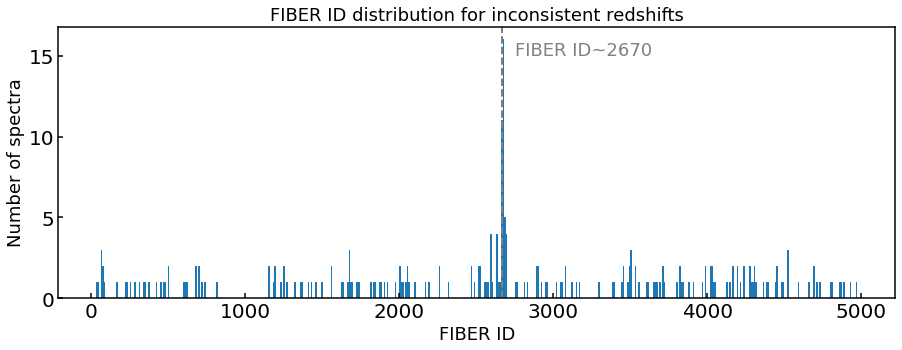

In [215]:
inconsistent_fiber_id = np.append(np.array(BGS_dz['dz_fuji']['FIBER']),np.array(LRG_dz['dz_fuji']['FIBER']))
inconsistent_fiber_id = np.append(inconsistent_fiber_id,np.array(ELG_dz['dz_fuji']['FIBER']))
plt.figure(figsize=(15,5))
_ = plt.hist(inconsistent_fiber_id,bins=500)
plt.xlabel('FIBER ID',fontsize=18)
plt.ylabel('Number of spectra',fontsize=18)
plt.axvline(2670,ls='--',color='grey',lw=2)
plt.text(2750,15,'FIBER ID~2670',fontsize=18,color='grey')
plt.title('FIBER ID distribution for inconsistent redshifts',fontsize=18)

In [216]:
BGS_main = main_survey_selection(BGS_data,'BGS_main')
LRG_main = main_survey_selection(LRG_data,'LRG_main')
ELG_main = main_survey_selection(ELG_data,'ELG_main')
ELG_top = main_survey_selection(ELG_data,'ELG_top')
ELG_low = main_survey_selection(ELG_data,'ELG_low')

Text(0.5, 0, 'Best VI redshift')

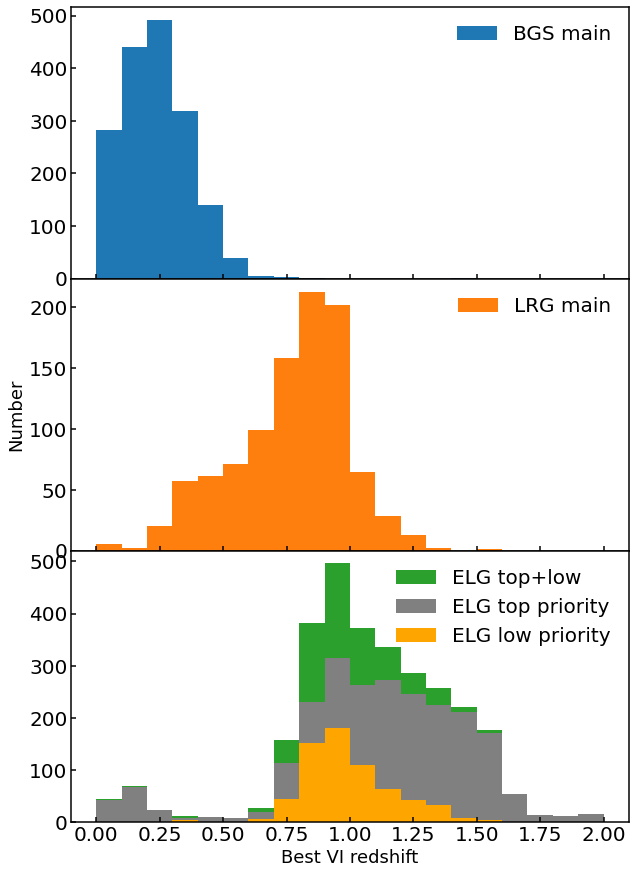

In [217]:
plt.figure(figsize=(10,15))
my_plot_style()
plt.subplots_adjust(hspace=0.)
plt.subplot(3,1,1)
plt.hist(BGS_main['best_z'][BGS_main['best_quality']>=2.5],range=(0,2),bins=20,label='BGS main')
plt.legend(frameon=False)
plt.subplot(3,1,2)
plt.ylabel('Number',fontsize=18)
plt.hist(LRG_main['best_z'][LRG_main['best_quality']>=2.5],range=(0,2),bins=20,color='C1',label='LRG main')
plt.legend(frameon=False)
plt.subplot(3,1,3)

plt.hist(ELG_main['best_z'][ELG_main['best_quality']>=2.5],range=(0,2),bins=20,color='C2',label='ELG top+low',alpha=1)
plt.hist(ELG_top['best_z'][ELG_top['best_quality']>=2.5],range=(0,2),bins=20,label='ELG top priority',color='grey',alpha=1)
plt.hist(ELG_low['best_z'][ELG_low['best_quality']>=2.5],range=(0,2),bins=20,label='ELG low priority',color='orange',alpha=1)
plt.legend(frameon=False)
plt.xlabel('Best VI redshift',fontsize=18)

In [218]:
print('Main survey selection')
print('---------------------------------------')
print('')
print('BGS')
BGS_dz = give_me_dz_inconsistent_statistics(BGS_main)
print('')
print('LRG ')
LRG_dz = give_me_dz_inconsistent_statistics(LRG_main)
print('')
print('ELG top+low priority')
ELG_dz = give_me_dz_inconsistent_statistics(ELG_main)
print('')
print('ELG top priority')

ELG_dz = give_me_dz_inconsistent_statistics(ELG_top)
print('')
print('ELG low priority')

ELG_dz = give_me_dz_inconsistent_statistics(ELG_low)

Main survey selection
---------------------------------------

BGS
Number of best quality>=2.5 & zwarn<=4 spectra:1795 (out of 1813 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 5 (0.3%)
Everest: 6 (0.3%)
Cascades: 23 (1.3%)

LRG 
Number of best quality>=2.5 & zwarn<=4 spectra:999 (out of 1013 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 12 (1.2%)
Everest: 12 (1.2%)
Cascades: 14 (1.4%)

ELG top+low priority
Number of best quality>=2.5 & zwarn<=4 spectra:3052 (out of 3565 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 35 (1.1%)
Everest: 40 (1.3%)
Cascades: 42 (1.4%)

ELG top priority
Number of best quality>=2.5 & zwarn<=4 spectra:2400 (out of 2897 VI spectra)
Number of spectra with inconsistent redshifts vs VI best z
Fuji: 31 (1.3%)
Everest: 34 (1.4%)
Cascades: 36 (1.5%)

ELG low priority
Number of best quality>=2.5 & zwarn<=4 spectra:652 (out of 668 VI spectra)
Number of spectra with inconsiste